# Figure 1:
Create figure of showing covariance between SO and variance metrics of tropical/subtropical variability (Precipitation, Walker Circulation, W-E Tropical Pacific Gradient, EPT)

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plotting Utils

In [2]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        psl = ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            levels=[-300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300] # Contours for PSL
        )

    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            colors="magenta",
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=25, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.05, .5, str(.5) + r' $\frac{m}{s}/K$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # Southern ITCZ 
    # bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


# Load Data

In [3]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# Maps of dX/dSO for 5-year anomalies CMIP Models
reg_so_dataset = xr.open_dataset(os.path.join(DATA_ROOT, "reg_so_dataset.nc"))
# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))
# Maps of dX/dSO for 5-year anomalies from Observations
obs_regs = xr.open_dataset(os.path.join(DATA_ROOT, "obs_so_regression_coeffs.nc"))
# dEPT/dSO at variance timescale: Obs
obs_sst_so_ept_reg = xr.open_dataset(os.path.join(DATA_ROOT, "obs_so_ept_coupling.nc"))

# Walker Circluation CMIP
reg_so_walker = xr.open_dataset(os.path.join(DATA_ROOT, "reg_so_walker.nc"))["reg_so_walker"]
p_so_walker = xr.open_dataset(os.path.join(DATA_ROOT, "p_so_walker.nc"))["p_so_walker"]
# WE Gradient CMIP
reg_so_WE = xr.open_dataset(os.path.join(DATA_ROOT, "reg_so_WE.nc"))["reg_so_WE"]
p_so_WE = xr.open_dataset(os.path.join(DATA_ROOT, "p_so_WE.nc"))["p_so_WE"]

# Figure 1

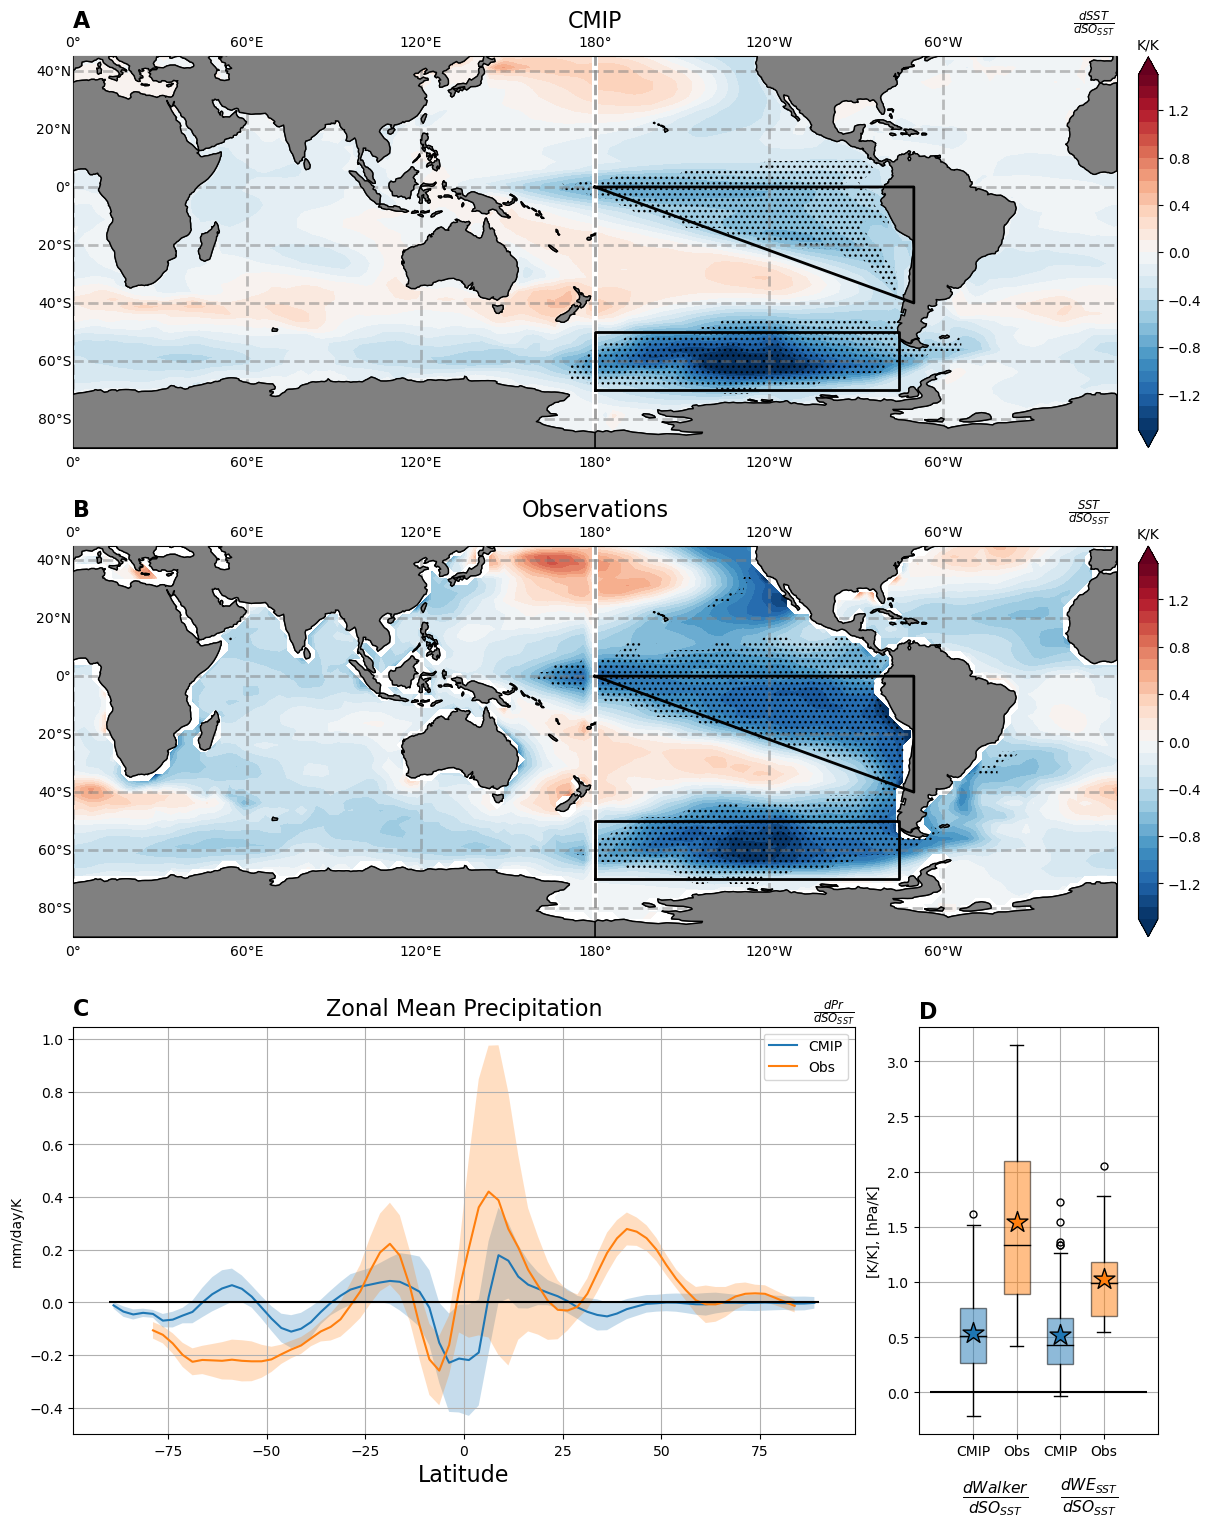

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import numpy as np

title_fontsize=16
# Create the figure and GridSpec
fig = plt.figure(figsize=(14, 18))  # Adjusted figure size
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1.5, 1.5, 1], wspace=0.2, hspace=0.2)

#################### CMIP REGRESSION MAP dSST/dSO ########################
ax1 = fig.add_subplot(gs[0, 0:3], projection=ccrs.PlateCarree(central_longitude=180))
# Add your map plotting code for ax1 here
img1 = _global_plot(
    ax1,
    data=-reg_so_dataset["reg_so_sst"].mean("model").values,
    lat=reg_so_dataset["reg_so_sst"].lat,
    lon=reg_so_dataset["reg_so_sst"].lon,
    levels=np.arange(-1.5, 1.6, .1),
    pvalues=reg_so_dataset["p_so_sst"],
    cmap="RdBu_r",
    # cbar_label=r"$C\degree/C\degree$",
    cbar_label=r"K/K",
)
ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
ax1.set_title("CMIP", loc="center", fontsize=title_fontsize)
avg_reg = rvalues_so_ept_coupling.mean("model").reg.sel(years=12*5).values
std_reg = rvalues_so_ept_coupling.std("model").reg.sel(years=12*5).values
# ax1.set_title(r"$\frac{dEPT}{dSO_{SST}}$ " + f"[{np.around(avg_reg, 2)}] $\pm$ {np.around(std_reg, 2)}", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"$\frac{dSST}{dSO_{SST}}$ ", loc="right", fontsize=title_fontsize*.75)
#########################################################################

#################### OBS REGRESSION MAP dSST/dSO ########################
ax2 = fig.add_subplot(gs[1, 0:3], projection=ccrs.PlateCarree(central_longitude=180))
# Add your map plotting code for ax1 here
img2 = _global_plot(
    ax2,
    data=-obs_regs["reg_sst"].mean("model"),
    lat=obs_regs["reg_sst"].latitude,
    lon=obs_regs["reg_sst"].longitude,
    levels=np.arange(-1.5, 1.6, .1),
    pvalues=((obs_regs["p_sst"] < .10).sum(dim="model") < obs_regs.model.size/2),
    cmap="RdBu_r",
    # cbar_label=r"$C\degree/C\degree$",
    cbar_label=r"K/K",
)
ax2.set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
# ax2.set_title(r"$\frac{dEPT}{dSO_{SST}}$ " + f"[{np.around(avg_reg, 2)} $\pm$  {np.around(std_reg, 2)}]", loc="right", fontsize=title_fontsize*.75)
ax2.set_title(r"$\frac{SST}{dSO_{SST}}$  ", loc="right", fontsize=title_fontsize*.75)
ax2.set_title("Observations", loc="center", fontsize=title_fontsize)
#########################################################################

#################### ZONAL MEAN PRECIP REGRESSION dPr/dSO ########################
ax_main = fig.add_subplot(gs[2, 0:2])
so_pr_mu = -reg_so_dataset["reg_so_pr"].mean(["model", "lon"]) * 86400
so_pr_std = -reg_so_dataset["reg_so_pr"].mean("lon").std(["model"]) * 86400
so_pr_mu.plot(ax=ax_main, label="CMIP")
ax_main.fill_between(
    reg_so_dataset.lat,
    so_pr_mu + so_pr_std,
    so_pr_mu - so_pr_std,
    alpha=0.25,
)
smoothed_data = (-obs_regs["reg_pr"].mean(["longitude"]) * 1000).rolling(latitude=5, center=True).mean()
ax_main.plot(smoothed_data.latitude, smoothed_data.mean("model"), label="Obs")
ax_main.fill_between(
    smoothed_data.latitude,
    smoothed_data.mean("model") + smoothed_data.std("model"),
    smoothed_data.mean("model") - smoothed_data.std("model"),
    alpha=0.25,
)
ax_main.grid()
ax_main.hlines(0, -90, 90, color="black")
# ax_main.set_ylabel("mm/day/°C")
ax_main.set_ylabel("mm/day/K")
ax_main.set_xlabel("Latitude", fontsize=title_fontsize)
ax_main.legend()
ax_main.set_title(r"Zonal Mean Precipitation", fontsize=title_fontsize)
ax_main.set_title(r"$\frac{dPr}{dSO_{SST}}$", loc="right")
ax_main.set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)

#################### REGRESSION dWE/dSO and dWalker/dSO ########################
ax_right = fig.add_subplot(gs[2, 2])
# ax_right.scatter(np.zeros(len(reg_so_walker.model)), -reg_so_walker, alpha=0.25, color="tab:blue", edgecolors="black", s=100)
# ax_right.scatter(
#     1 + np.zeros(len(obs_regs.model)), -obs_regs["reg_walker"] / 100, edgecolors="black", color="tab:orange", s=100, alpha=0.75
# )
# ax_right.scatter(0, -reg_so_walker.mean("model"), edgecolors="black", color="tab:blue", marker="*", s=500)
# ax_right.scatter(1, -obs_regs["reg_walker"].mean("model") / 100, edgecolors="black", color="tab:orange", marker="*", s=500)
# ax_right.scatter(np.zeros(len(reg_so_WE.model)) + 2, -reg_so_WE, alpha=0.25, color="tab:blue", edgecolors="black", s=100)
# ax_right.scatter(
#     np.zeros(len(obs_regs.model)) + 3, -obs_regs["reg_we"], edgecolors="black", color="tab:orange", s=100, alpha=0.75
# )
# ax_right.scatter(2, -reg_so_WE.mean("model"), edgecolors="black", color="tab:blue", marker="*", s=500)
# ax_right.scatter(3, -obs_regs["reg_we"].mean("model"), edgecolors="black", color="tab:orange", marker="*", s=500)
# ax_right.set_xticks([0, 1, 2, 3])
# ax_right.set_xlim(-1, 4)

colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
boxprops = dict(color='black')
medianprops = dict(color='black')
whiskerprops = dict(color='black')
capprops = dict(color='black')
flierprops = dict(marker='o', markersize=5, linestyle='none', color='gray')

bp = ax_right.boxplot(
    data_boxplots,
    positions=[0, 1, 2, 3],
    widths=0.6,
    patch_artist=True,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    flierprops=flierprops
)

# Set facecolor of each box to match original colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5) 
    
# Overlay mean markers
starSize = 250 
ax_right.scatter(0, -reg_so_walker.mean("model"), color=colors[0], edgecolors="black", marker="*", s=starSize, zorder=3)
ax_right.scatter(1, -obs_regs["reg_walker"].mean("model") / 100, color=colors[1], edgecolors="black", marker="*", s=starSize, zorder=3)
ax_right.scatter(2, -reg_so_WE.mean("model"), color=colors[2], edgecolors="black", marker="*", s=starSize, zorder=3)
ax_right.scatter(3, -obs_regs["reg_we"].mean("model"), color=colors[3], edgecolors="black", marker="*", s=starSize, zorder=3)


ax_right.set_xticklabels(["CMIP", "Obs", "CMIP", "Obs"])
# ax_right.set_xticklabels([r"        $\frac{dWalker}{dSO_{SST}}$", "", r"        $\frac{dWE_{SST}}{dSO_{SST}}$", ""], fontsize=title_fontsize)
ax_right.text(-.25, -1, r"$\frac{dWalker}{dSO_{SST}}$", ha="left", fontsize=title_fontsize)
ax_right.text(2, -1, r"$\frac{dWE_{SST}}{dSO_{SST}}$", ha="left", fontsize=title_fontsize)
ax_right.set_title("D", loc="left", fontweight="bold", fontsize=title_fontsize)
ax_right.set_ylabel("[K/K], [hPa/K]")
ax_right.hlines(0, -1, 4, color="black")
ax_right.grid()
#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_1_v2.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_1_v2.pdf", dpi=300, bbox_inches="tight")

# Figure SX
Model Maps of regression coeffs between SO and CRE, SWCRE, LWCRE and winds, and MSLP

In [6]:
reg_so_dataset = xr.open_dataset(os.path.join(DATA_ROOT, "reg_so_dataset.nc"))
reg_so_dataset

<xarray.Dataset>
Dimensions:       (model: 94, lat: 72, lon: 144)
Coordinates:
  * model         (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'inmcm4'
  * lat           (lat) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon           (lon) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Data variables: (12/16)
    reg_so_sst    (model, lat, lon) float64 ...
    p_so_sst      (lat, lon) bool ...
    reg_so_pr     (model, lat, lon) float64 ...
    p_so_pr       (lat, lon) bool ...
    reg_so_psl    (model, lat, lon) float64 ...
    p_so_psl      (lat, lon) bool ...
    ...            ...
    reg_so_swcre  (model, lat, lon) float64 ...
    p_so_swcre    (lat, lon) bool ...
    reg_so_lwcre  (model, lat, lon) float64 ...
    p_so_lwcre    (lat, lon) bool ...
    reg_so_cre    (model, lat, lon) float64 ...
    p_so_cre      (lat, lon) bool ...

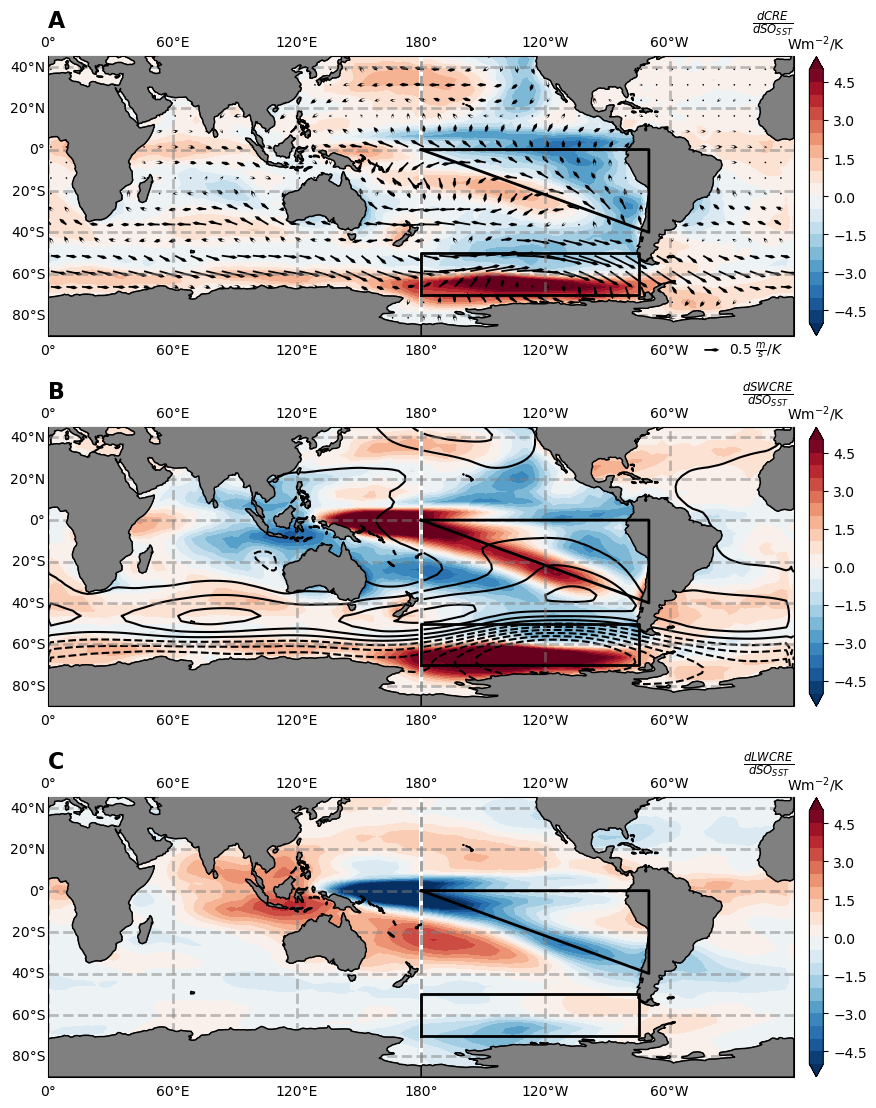

In [39]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import numpy as np

# Define title font size
title_fontsize = 16

# Create the figure and GridSpec
fig = plt.figure(figsize=(10, 14))  # Adjusted for single-column layout
gs = GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.1)

# Top row: reg_so_cre with wind barbs
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
img1 = _global_plot(
    ax1,
    data=-reg_so_dataset["reg_so_cre"].mean("model").values,
    lat=reg_so_dataset["reg_so_cre"].lat,
    lon=reg_so_dataset["reg_so_cre"].lon,
    levels=np.arange(-5, 5.5, 0.5),
    wind={"uas": -reg_so_dataset["reg_so_uas"].mean("model").values, "vas": -reg_so_dataset["reg_so_vas"].mean("model").values},
    cmap="RdBu_r",
    cbar_label=r"Wm$^{-2}$/K",
    # pvalues=reg_so_dataset["p_so_cre"],
)
ax1.set_title("A", loc="left", fontweight="bold", fontsize=title_fontsize)
ax1.set_title(r"$\frac{dCRE}{dSO_{SST}}$", loc="right")

# Middle row: reg_so_swcre
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
img2 = _global_plot(
    ax2,
    data=-reg_so_dataset["reg_so_swcre"].mean("model").values,
    lat=reg_so_dataset["reg_so_swcre"].lat,
    lon=reg_so_dataset["reg_so_swcre"].lon,
    levels=np.arange(-5, 5.5, 0.5),
    cmap="RdBu_r",
    cbar_label=r"Wm$^{-2}$/K",
    contours=-reg_so_dataset["reg_so_psl"].mean("model").values,
    # pvalues=reg_so_dataset["p_so_swcre"],
)
ax2.set_title("B", loc="left", fontweight="bold", fontsize=title_fontsize)
ax2.set_title(r"$\frac{dSWCRE}{dSO_{SST}}$", loc="right")

# Bottom row: reg_so_lwcre
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
img3 = _global_plot(
    ax3,
    data=-reg_so_dataset["reg_so_lwcre"].mean("model").values,
    lat=reg_so_dataset["reg_so_lwcre"].lat,
    lon=reg_so_dataset["reg_so_lwcre"].lon,
    levels=np.arange(-5, 5.5, 0.5),
    cmap="RdBu_r",
    cbar_label=r"Wm$^{-2}$/K",
    # pvalues=reg_so_dataset["p_so_lwcre"],
)
ax3.set_title(r"$\frac{dLWCRE}{dSO_{SST}}$", loc="right")
ax3.set_title("C", loc="left", fontweight="bold", fontsize=title_fontsize)

# Save figure
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_dCREdSO.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_dCREdSO.pdf", dpi=300, bbox_inches="tight")
